<a href="https://colab.research.google.com/github/lindermanlab/PPSeq/blob/main/notebooks/version4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PPSeq with GPU support

The original PPSeq algorithm worked in continuous time and used a collapsed Gibbs sampler for nonparametric Bayesian inference. Unfortunately, the collapsed algorithm introduced serial dependencies that could make computation slow on some datasets. Here, we implement a simpler inference algorithm that works in discrete time takes advantage of parallelization across time bins using a GPU.

## Model

Like PPSeq, the model is a simple convolutional non-negative matrix factorization,

$$
\begin{align}
x_{n,t} &\sim \mathrm{Po}(\lambda_{n,t}) \\
\lambda_{n,t} &= b_n + \sum_{k=1}^K \sum_{d=1}^D a_{k,t-d} w_{k,n,d} \\
 &= b_n + \sum_{k=1}^K [\mathbf{a}_{k} \circledast \mathbf{w}_{k,n}]_t
\end{align}
$$
where
- $a_{k,t} \in \mathbb{R}_+$ is the **amplitude** of the $k$-th factor at time $t$.
- $w_{k,n,d}$ is the weight the $k$-th factor assigns to neuron $n$ at time delay $d$.
- $\circledast$ denotes a convolution.

A simple way to fit this model is by augmentation: we introduce latent **parent assignments** $z_{n,t,k}$ which specify how many of the spikes $x_{n,t}$ were attributed to each of the $KD+1$ factors (including the background). Given the parents, updating estimates of parametesr $\mathbf{a}$ and $\mathbf{w}$ is relatively straightforward.


## Augmentation

Let
$$
\begin{align}
z_{n,t,0} &\sim \mathrm{Po}(b_n) \\
z_{n,t,k,d} &\sim \mathrm{Po}(a_{k,t-d} w_{k,n,d})
\end{align}
$$
Then $x_{n,t} = z_{n,t,0} + \sum_k \sum_d z_{n,t,k,d}$ (in distribution). Moreover, given the sum, the parent variables are multinomial distributed with expectations,
\begin{align}
\mathbb{E}[z_{n,t,0} \mid x_{n,t}, \theta]
&= \frac{x_{n,t}}{\lambda_{n,t}} b_n \\
&= r_{n,t} b_n \\
\mathbb{E}[z_{n,t,k,d} \mid x_{n,t}, \theta]
&= \frac{x_{n,t}}{\lambda_{n,t}} a_{k,t-d} w_{k,n,d} \\
&= r_{n,t} a_{k,t-d} w_{k,n,d}
\end{align}
where $\theta = \{\mathbf{b}, \mathbf{a}_k, \mathbf{w}_k\}$ is the set of model parameters, and $r_{n,t} = \frac{x_{n,t}}{\lambda_{n,t}}$ are we call the **residual ratios**.

## Inference
## M-step for b
Assume that the base rate follows a gamma prior $b_n\sim \mathrm{Ga}(b_n\mid \alpha_0, \beta_0)$

\begin{align}
L(b_n) = \log P(b_n|z_{n, t,0}, t\in[T])
&= \sum_t \log Po(z_{n, t,0}|b_n)+c\\
&= \sum_t z_{n,t,0}\log b_n - T b_n
\end{align}

maximized at $b_n = max((\sum_t\mathbb{E}[z_{n,t,0}]/T=\sum_t r_{n,t}b_n + \alpha_0 -1) /(T + \beta_0), 0)$




### M-step for the amplitudes
If we work with the log joint probability as a function of $\mathbf{a}_{k,t}$,
assuming that the prior of it is $\mathbf{a}_{k,t}\sim \mathrm{Ga}(a_{k,t} \mid \alpha_0, \beta_0)$
\begin{align}
L(\mathbf{a}_{k,t})
&=  \mathrm{Ga}(a_{k,t} \mid \alpha_0, \beta_0)\sum_{n=1}^N \sum_{d=1}^D \log \mathrm{Po}(z_{n,t+d,k,d} \mid a_{k,t} w_{k,n,d}) + c\\
&=  \sum_{n=1}^N \sum_{d=1}^D z_{n,t+d,k,d} \log a_{k,t} - a_{k,t} w_{k,n,d} + c \\
&=  \log \mathrm{Ga}(a_{k,t} \mid \alpha_{k,t}+\alpha_0, \beta_{k,t}+\beta_0)
\end{align}
<!-- &= \sum_{t=1}^T \alpha_{k,t} \log a_{k,t} - \beta a_{k,t} -->
where
\begin{align}
\alpha_{k,t} &= \sum_{n=1}^N \sum_{d=1}^D z_{n,t+d,k,d} \\
\beta_{k,t} &= \sum_{n=1}^N \sum_{d=1}^D w_{k,n,d}
\end{align}

For EM, we need the expected value of the gamma parameters.
\begin{align}
\mathbb{E}[\alpha_{k,t}]
&= a'_{k,t} \sum_{n=1}^N \sum_{d=1}^D w_{k,n,d} \, r_{n,t+d} \\
&= a'_{k,t} [\mathbf{W}_k \ast \mathbf{R}]_t \\
\end{align}
where $a_{k,t}'$ are the amplitudes from the previous iteration and $\ast$ denotes the **cross-correlation** operation.
<!--
$\log \mathbb{E} p(x,z|\theta) \geq \text{(ELBO)} \mathbb{E}_{z\sim \text{multinomial}}[\log  p(x,z|\theta)] $

Focus only on $a_{k,t}$:

$\text{ELBO}(a_{k,t})=\sum_{n=1}^N \sum_{d=1}^D \mathbb{E}[z_{n,t+d,k,d}] \log a_{k,t} - a_{k,t} w_{k,n,d} $
-->
The mode is $a_{k,t}= max(\frac{\mathbb{E}[\alpha_{k,t}]+\alpha_0-1}{\beta_{k,t}}, 0)$


### M-step for the weights
As a function of the weights, the log joint probability is,
\begin{align}
L(\mathbf{w}_{k,n})
&= \sum_{d=1}^D \sum_{t=1}^T \log \mathrm{Po}(z_{n,t,k,d} \mid a_{k,t} w_{k,n,d}) + c \\
&= \sum_{d=1}^D \log \mathrm{Ga}(w_{k,n,d} \mid \alpha_{k,n,d}, \beta_{k,n,d})
\end{align}
where
\begin{align}
\alpha_{k,n,d} &= \sum_{t=1}^T z_{n,t,k,d} \\
\beta_{k,n,d} &= \sum_{t=T}^T a_{k,t}
\end{align}
In expectation,
\begin{align}
\mathbb{E}[\alpha_{k,n,d}]
&= w_{k,n,d}' \sum_{t=1}^T \frac{x_{n,t}}{\lambda_{n,t}} a_{k,t-d} \\
&= w_{k,n,d}' \sum_{t=1}^T \mathbf{r}_{n,t} a_{k,t-d}\\
&= w_{k,n,d}' [\mathbf{r}_{n} \circledast \mathbf{a}_k]_d
\end{align}

## Code

In [1]:
# !git clone https://github.com/lindermanlab/ppseq-pytorch.git
# %cd ppseq-pytorch
# !pip install -e .

Cloning into 'PPSeq'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 105 (delta 44), reused 45 (delta 17), pack-reused 0
Receiving objects: 100% (105/105), 899.29 KiB | 3.64 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/PPSeq


In [3]:
from src.plot_tools import plot_model, plot_sorted_neurons, sort_neurons, color_plot
from src.em import pred, log_probability, em

import numpy as np
import math
import pandas as pd

# Import PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
import torch.optim as optim

import matplotlib.pyplot as plt

from tqdm.auto import trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print('cpu')

import pandas as pd
import math
import numpy as np
url = 'https://raw.githubusercontent.com/lindermanlab/PPSeq/main/src/songbird_spikes.txt'
df = pd.read_csv(url, delimiter='\t', header=None)
x = df.groupby(0)[1].apply(list).to_numpy()

T = 223 # df[1].max()
n = 75
X = torch.zeros(n, T)#.to(device)
for i, neuron in enumerate(x):
  for spike in neuron:
    X[i, math.ceil(spike*10)] += 1
X = X[~torch.all(X == 0, dim=1)]

/content/PPSeq/src/em.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.tensor(torch.ones(K, N) * D/2, requires_grad=True, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

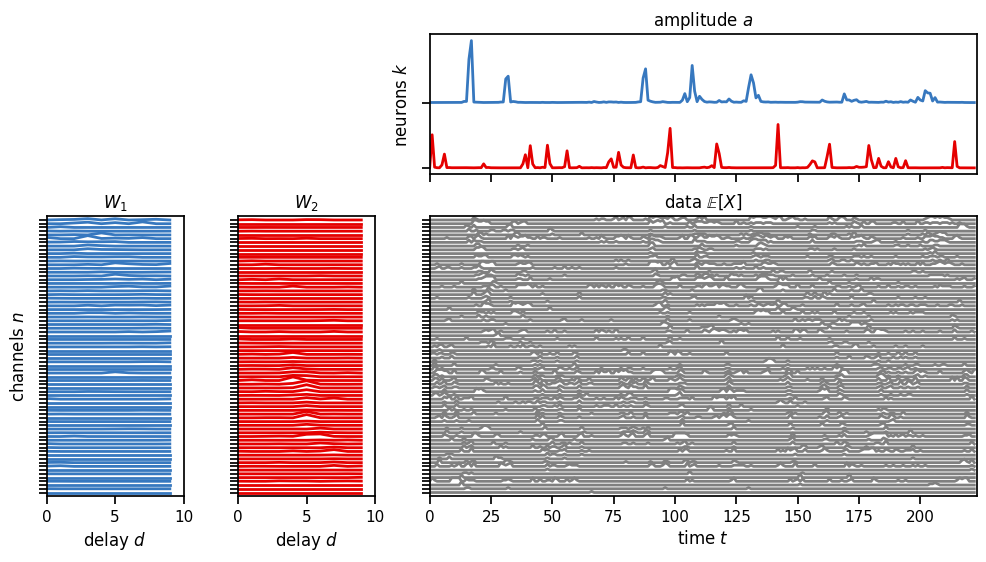

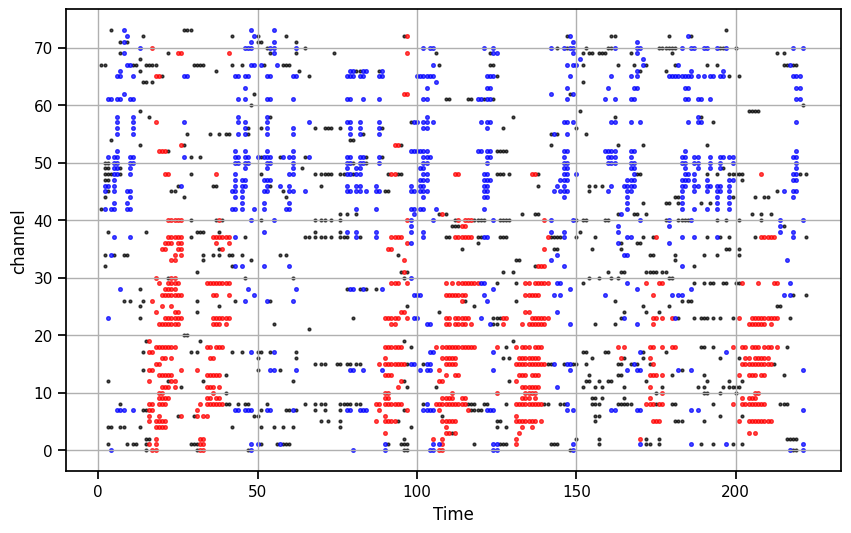

In [6]:
D = 10    # duration of a spike (in samples)
K = 2

b_pred, a_pred, w_pred, lps,scale, mu, log_sigma, loss_hist, W_prediction = em(X, K, D, n_iter=1000, alpha_a0 = 1.5, beta_a0 = 0.1, alpha_b0 = 14, beta_b0=0.4)
plot_model(w_pred.cpu(), a_pred.cpu(), X.cpu())
#plot_sorted_neurons(X.cpu()[sort_neurons(X.cpu(), scale, mu)])
color_plot(X.cpu(), b_pred, a_pred, w_pred, scale, mu)

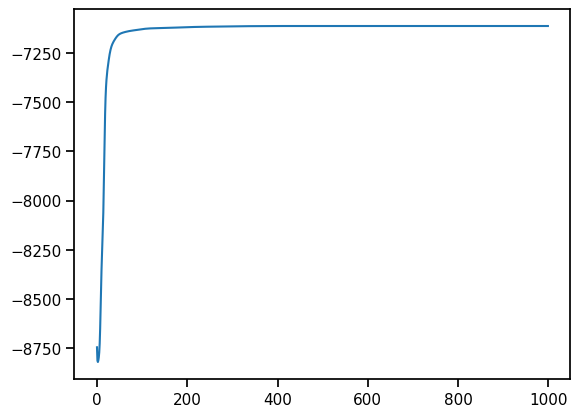

In [8]:
plt.plot([x.detach().cpu() for x in lps])